In [1]:
%%capture
BASEPATH = '../'
import sys
sys.path.insert(0,'..')

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from pyecg.utils import reset_seed, plot_spectogram, plot_loss, load_data
from pyecg.utils import integer_mapping, mapping_AAMI, calc_class_weights
from pyecg.data_info import *
from pyecg.data_preprocessing import clean_inf_nan,clean_IQR,clean_IQR_class
from pyecg.data_handling import DataHandling,slice_data
from pyecg.report import Reports
from pyecg.utils import sig_similarity_report,sig_similarity_hist


reset_seed() 

2022-06-09 18:27:23.963196: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 18:27:23.963268: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-09 18:27:49.881896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-09 18:27:49.881941: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 18:27:49.881975: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-06-09 18:27:49.882357: I tensorflow/core/platform/cpu_feature_gua

# Proto

In [2]:
datasets = {1:'raw',2:'stft'}

CONFIG = {}
CONFIG['dataset'] = datasets[1]
CONFIG['augment'] = False 
CONFIG['sliced_targets'] = {'N':0,'A':1,'V':2}    #{'N':0,'A':1,'V':2} #None  #{'N':0,'A':1}
CONFIG['AAMI'] = False 
CONFIG['class_weight'] = False 
CONFIG['normalization'] = 'zscore'       #'zscore' 'minmax' , None, 'max' 

# Data

In [3]:
#Load data
dh = DataHandling(base_path='../data')

if CONFIG['dataset'] == 'raw':
    ds_train = dh.load_data(file_name = 'train.beat')
    x_train, r_train, y_train = ds_train.values()
    
    ds_val = dh.load_data(file_name = 'val.beat')
    x_val, r_val, y_val = ds_val.values()
    

file loaded: ../data/train.beat
shape of "waveforms" is (38949, 1000)
shape of "beat_feats" is (38949, 62)
shape of "labels" is (38949,)
                N     L     R   j  e     V    E    A  S   a   J    F  f  /  Q
train.beat  27374  3849  3570  14  0  2931  105  580  2  97  32  387  0  0  8
file loaded: ../data/val.beat
shape of "waveforms" is (9872, 1000)
shape of "beat_feats" is (9872, 62)
shape of "labels" is (9872,)
             N  L  R  j   e    V  E    A  S  a  J   F  f  /  Q
val.beat  9049  0  0  0  16  625  0  166  0  1  0  15  0  0  0


In [32]:
ds_train = clean_inf_nan(ds_train)
x_train, r_train, y_train = ds_train.values()
y_train.shape

(814,)

In [5]:
xx =  x_train.flatten()
max(xx),min(xx),sum(xx)/len(xx) 

(4.118348992851702, -3.531306100843774, 0.04888668081381855)

In [6]:
rr =  r_train.flatten()
max(rr),min(rr),sum(rr)/len(rr) 

(100.02222222222225, -50.18046660868458, 0.29059396895927475)

In [7]:
np.median(r_train,axis=0)

array([ 9.96015936e-01,  1.00000000e+00,  1.00000000e+00, -3.79605508e+00,
        5.13790599e-02,  3.02326483e-01,  3.20341890e+00,  1.20063381e+01,
        3.10661409e-01,  1.00000000e+00, -6.62313676e-03, -7.14307312e-03,
       -6.32050982e-03, -3.82306686e-03, -3.07995497e-03, -1.80808869e-04,
        8.40501261e-03,  2.51194470e-02,  3.99220068e-02,  4.17309439e-02,
        2.45056697e-02,  7.77686323e-03, -3.70688854e-03, -1.57081765e-02,
       -2.27462612e-02, -2.24957964e-02, -1.33961003e-02,  1.54575645e-02,
        2.35646608e-01,  3.54108886e-01,  1.07013322e-01, -7.86472161e-04,
       -3.89409600e-02, -7.39596912e-02, -8.13719422e-02, -8.07600021e-02,
       -7.70853007e-02, -7.16591157e-02, -6.44899611e-02, -5.25882828e-02,
       -4.12161540e-02, -3.07620054e-02, -1.82588163e-02, -6.25462176e-03,
        3.23706808e-03,  1.24844296e-02,  2.25034276e-02,  2.87622774e-02,
        3.15468395e-02,  3.30196087e-02,  3.07280159e-02,  2.56762042e-02,
        1.86820348e-02,  

<AxesSubplot:>

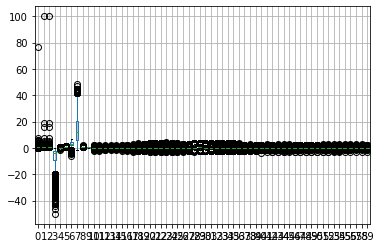

In [8]:
r_train.shape
pd.DataFrame(r_train).boxplot()

In [9]:
list(np.unique(y_train))

['A', 'E', 'F', 'J', 'L', 'N', 'Q', 'R', 'S', 'V', 'a', 'j']

In [10]:
#cleaning
ds_train = clean_IQR_class(ds_train,factor=2)  #29.0

In [120]:
x_train, r_train, y_train = ds_train.values()
r_train.shape

(38949, 60)

<AxesSubplot:>

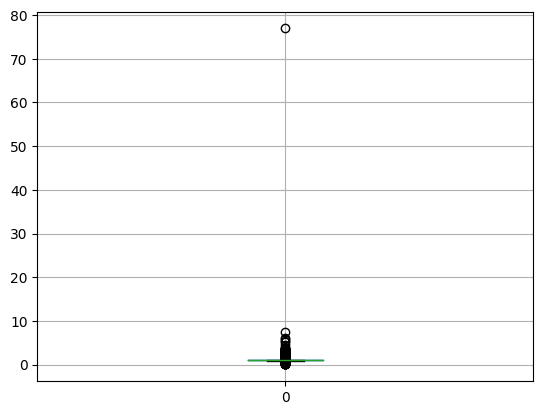

In [121]:
pd.DataFrame(r_train[:,0]).boxplot()

In [13]:
rr =  r_train.flatten()
max(rr),min(rr),sum(rr)/len(rr) 

(42.60326727553526, -27.615572205873487, 0.3123833648158454)

In [14]:
ix = dh.search_label(ds_train,'N')

In [15]:
rp1 = dh.report_stats_table([y_train, y_val], ['train','val'])
rp1 

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
train,11065,2615,1967,0,0,1194,57,141,2,42,17,243,0,0,3
val,9049,0,0,0,16,625,0,166,0,1,0,15,0,0,0


In [4]:
#slice data
if CONFIG['sliced_targets'] is not None:
    from pyecg.data_handling import slice_data
    sliced_targets = CONFIG['sliced_targets']
    ds_train = slice_data(ds_train, sliced_targets)
    x_train, r_train, y_train = ds_train.values()
    ds_val = slice_data(ds_val, sliced_targets)
    x_val, r_val, y_val = ds_val.values()
    rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
    print(rp2)

           N  L  R  j  e     V  E    A  S  a  J  F  f  /  Q
train  27374  0  0  0  0  2931  0  580  0  0  0  0  0  0  0
val     9049  0  0  0  0   625  0  166  0  0  0  0  0  0  0


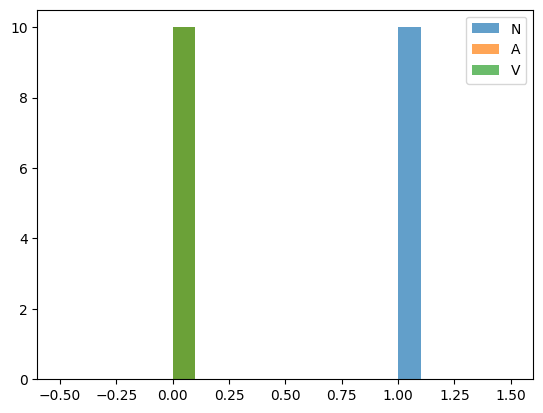

In [18]:
ftno = 9
sliced_targets = {'N':0}
ds_trainA = slice_data(ds_train, sliced_targets)
x_trainA, r_trainA, y_trainA = ds_trainA.values()
plt.hist(r_trainA[:,ftno],density=True, alpha=0.7)

sliced_targets = {'A':1}
ds_trainA = slice_data(ds_train, sliced_targets)
x_trainA, r_trainA, y_trainA = ds_trainA.values()
plt.hist(r_trainA[:,ftno],density=True, alpha=0.7)

sliced_targets = {'V':2}
ds_trainN = slice_data(ds_train, sliced_targets)
x_trainN, r_trainN, y_trainN = ds_trainN.values()
plt.hist(r_trainN[:,ftno],density=True, alpha=0.7)

plt.legend(['N','A','V'])

In [19]:
np.median(r_trainA[:,0])

1.0070921985814938

In [289]:
#Normalization
if CONFIG['normalization'] == 'zscore':
    from sklearn.preprocessing import StandardScaler
    standardscaler_x = StandardScaler()
    x_train = standardscaler_x.fit_transform(x_train)
    x_val = standardscaler_x.transform(x_val) 
    
    standardscaler_r = StandardScaler()
    r_train = standardscaler_r.fit_transform(r_train)
    r_val = standardscaler_r.transform(r_val) 

if CONFIG['normalization'] == 'minmax':
    from sklearn.preprocessing import MinMaxScaler
    scaler_x = MinMaxScaler(feature_range=(-1,1)) 
    if len(x_train[0].shape)==1:
        x_train = scaler_x.fit_transform(x_train)
        x_val = scaler_x.transform(x_val)
    elif len(x_train[0].shape)==2:
        org_shape = x_train.shape
        x_train = scaler_x.fit_transform(x_train.reshape((-1,1)))
        x_train = x_train.reshape(org_shape)
        org_shape = x_val.shape
        x_val = scaler_x.transform(x_val.reshape((-1,1)))
        x_val = x_val.reshape(org_shape)

    scaler_r = MinMaxScaler(feature_range=(-1,1))
    r_train = scaler_r.fit_transform(r_train)
    r_val = scaler_r.transform(r_val)   

if CONFIG['normalization'] == 'max':   
    max_x_train = max(x_train.flatten())
    x_train = x_train/max_x_train
    x_val = x_val/max_x_train

xx =  x_train.flatten()
max(xx),min(xx),sum(xx)/len(xx)

(39.55191872817411, -22.662638422927984, 3.3623577062122115e-15)

In [143]:
rr =  r_train.flatten()
max(rr),min(rr),sum(rr)/len(rr) 

(42.60326727553526, -27.010137602056382, 0.982036132369804)

<AxesSubplot:>

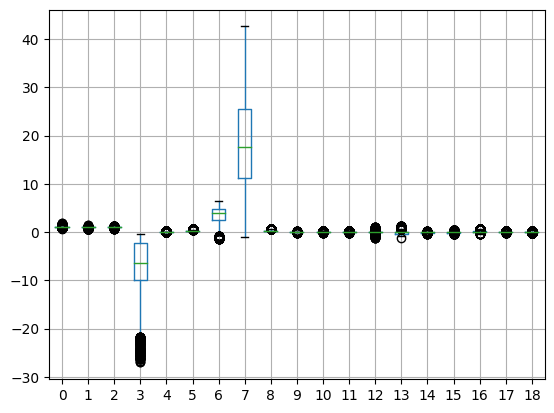

In [144]:
#normalized
pd.DataFrame(r_train).boxplot()

In [145]:
if CONFIG['AAMI']:
    y_train = mapping_AAMI(y_train, MAP_AAMI)
    y_val = mapping_AAMI(y_val, MAP_AAMI)

In [146]:
rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
print(rp2) 

           N  L  R  j  e  V  E    A  S  a  J  F  f  /  Q
train  16821  0  0  0  0  0  0  367  0  0  0  0  0  0  0
val     9353  0  0  0  0  0  0  169  0  0  0  0  0  0  0


In [147]:
#augment
if CONFIG['augment']==True:
    from pyecg.data_augmentation import aug_decrease,aug_increase
    ds_train = aug_decrease(ds_train, label='N', desired_size = 12000)
    ds_train = aug_increase(ds_train, desired_size = 12000)
    x_train, r_train, y_train = ds_train.values()
    
rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
print(rp2)

           N  L  R  j  e  V  E    A  S  a  J  F  f  /  Q
train  16821  0  0  0  0  0  0  367  0  0  0  0  0  0  0
val     9353  0  0  0  0  0  0  169  0  0  0  0  0  0  0


In [148]:
np.unique(y_train), r_train.shape 

(array(['A', 'N'], dtype='<U1'), (17188, 19))

# Load Preprocessed Test Set

In [5]:
#Load Preprocessed Test Set
dh = DataHandling(base_path='../data')
if CONFIG['dataset'] == 'raw':
    ds_test = dh.load_data(file_name = 'test.beat')
    ds_test = clean_inf_nan(ds_test)
    x_test, r_test, y_test = ds_test.values()   
    
elif CONFIG['dataset'] == 'stft':
    ds_test = dh.load_data(file_name = 'DS2_stft.dat')
    x_test, y_test, r_test = ds_test.values() 

file loaded: ../data/test.beat
shape of "waveforms" is (47512, 1000)
shape of "beat_feats" is (47512, 62)
shape of "labels" is (47512,)
               N     L     R    j  e     V  E     A  S   a   J    F  f  /  Q
test.beat  34811  3937  3300  213  0  3104  1  1657  0  48  51  383  0  0  7


In [6]:
#slice test data
if CONFIG['sliced_targets'] is not None:
    from pyecg.data_handling import slice_data
    sliced_targets = CONFIG['sliced_targets']
    ds_test = slice_data(ds_test, sliced_targets)
    x_test, r_test, y_test = ds_test.values()

In [7]:
rp2 = dh.report_stats_table([y_test], ['test'])
rp2

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
test,34811,0,0,0,0,3104,0,1657,0,0,0,0,0,0,0


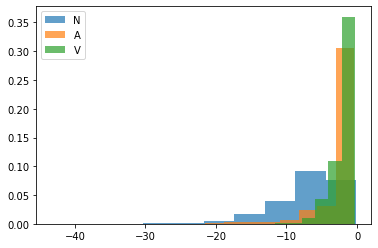

In [28]:
ftno = 5
sliced_targets = {'N':0}
ds_trainA = slice_data(ds_test, sliced_targets)
x_trainA, r_trainA, y_trainA = ds_trainA.values()
plt.hist(r_trainA[:,ftno],density=True, alpha=0.7)

sliced_targets = {'A':1}
ds_trainA = slice_data(ds_test, sliced_targets)
x_trainA, r_trainA, y_trainA = ds_trainA.values()
plt.hist(r_trainA[:,ftno],density=True, alpha=0.7)

sliced_targets = {'V':2}
ds_trainN = slice_data(ds_test, sliced_targets)
x_trainN, r_trainN, y_trainN = ds_trainN.values()
plt.hist(r_trainN[:,ftno],density=True, alpha=0.7)

plt.legend(['N','A','V'])

In [152]:
y_true = y_test.copy()

if CONFIG['AAMI']:
    y_true = mapping_AAMI(y_true, MAP_AAMI)

In [120]:
if CONFIG['normalization'] == 'zscore':
    x_test = standardscaler_x.transform(x_test) 
    r_test = standardscaler_r.transform(r_test) 

if CONFIG['normalization'] == 'minmax':
    x_test = scaler_x.transform(x_test)
    r_test = scaler_r.transform(r_test)
    
if CONFIG['normalization'] == 'max':   
    x_test = x_test/max_x_train

# ML classical (RF)

In [8]:
r_train.shape,y_train.shape,r_val.shape,y_val.shape

((30885, 62), (30885,), (9840, 62), (9840,))

In [9]:
rp2 = dh.report_stats_table([y_train, y_val, y_test], ['train','val','test'])
print(rp2)

           N  L  R  j  e     V  E     A  S  a  J  F  f  /  Q
train  27374  0  0  0  0  2931  0   580  0  0  0  0  0  0  0
val     9049  0  0  0  0   625  0   166  0  0  0  0  0  0  0
test   34811  0  0  0  0  3104  0  1657  0  0  0  0  0  0  0


In [53]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,
                             criterion='entropy', #gini entropy
                             min_samples_split=10,
                             min_samples_leaf=10,
                             class_weight='balanced_subsample', #balanced_subsample 'balanced' None
                             ccp_alpha=0.0,
                             bootstrap=True,
                             #max_samples=200,
                             random_state=747,
                             warm_start=False,
                             n_jobs=-1)
feats = [0,4,5,7,9,11]
#feats = list(range(0,12))
print(feats)
clf.fit(r_train[:,feats], y_train)

[0, 4, 5, 7, 9, 11]


RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       min_samples_leaf=10, min_samples_split=10, n_jobs=-1,
                       random_state=747)

In [54]:
y_true = y_train
y_pred = clf.predict(r_train[:, feats])
#y_pred = integer_mapping(y_pred, FINAL_MAP_DICT, inverse=True)

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred)) 

              precision    recall  f1-score   support

           A       0.96      1.00      0.98       580
           N       1.00      1.00      1.00     27374
           V       1.00      0.99      1.00      2931

    accuracy                           1.00     30885
   macro avg       0.99      1.00      0.99     30885
weighted avg       1.00      1.00      1.00     30885

[[  578     0     2]
 [    0 27374     0]
 [   26     0  2905]]


In [55]:
y_true = y_val
y_pred = clf.predict(r_val[:, feats])
#y_pred = integer_mapping(y_pred, FINAL_MAP_DICT, inverse=True)

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred)) 

              precision    recall  f1-score   support

           A       0.77      0.90      0.83       166
           N       1.00      1.00      1.00      9049
           V       0.97      0.93      0.95       625

    accuracy                           0.99      9840
   macro avg       0.91      0.94      0.93      9840
weighted avg       0.99      0.99      0.99      9840

[[ 150    0   16]
 [   0 9049    0]
 [  46    0  579]]


In [56]:
y_true = y_test
y_pred = clf.predict(r_test[:, feats])
#y_pred = integer_mapping(y_pred, FINAL_MAP_DICT, inverse=True)

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred)) 

              precision    recall  f1-score   support

           A       0.92      0.74      0.82      1657
           N       1.00      1.00      1.00     34811
           V       0.87      0.97      0.92      3104

    accuracy                           0.99     39572
   macro avg       0.93      0.90      0.91     39572
weighted avg       0.99      0.99      0.99     39572

[[ 1221     0   436]
 [    0 34811     0]
 [  104     0  3000]]


In [23]:
from tqdm import tqdm
def plot_misclassifications(ytrue,ypred,ds):
    for i in tqdm(range(len(ypred))):
        if ypred[i] != ytrue[i]:
            from matplotlib import figure
            fig = figure.Figure(figsize=(8,4),dpi=170)
            ax = fig.add_subplot(111)
            waveform = ds['waveforms'][i]
            ax.plot(waveform)
            title = 'True: {} >> Pred: {}'.format(ytrue[i],y_pred[i])
            ax.set_title(title)
            ax.set_ylim(-1,2)
            fldr = "../misplots/{}".format(ytrue[i])
            try:
                import os
                os.makedirs(fldr, exist_ok = True) 
            except OSError as err:
                    print("Folder can not be created!")
            fig.savefig('{}/{}.jpg'.format(fldr, str(i)))
            fig.clear()

plot_misclassifications(y_true, y_pred,ds_test)          

100%|████████████████████████████████████| 39572/39572 [01:11<00:00, 555.16it/s]


In [144]:
fi = clf.feature_importances_

In [145]:
finame=(
['ratio_pre_avg', 'ratio_post_avg'])

<BarContainer object of 6 artists>

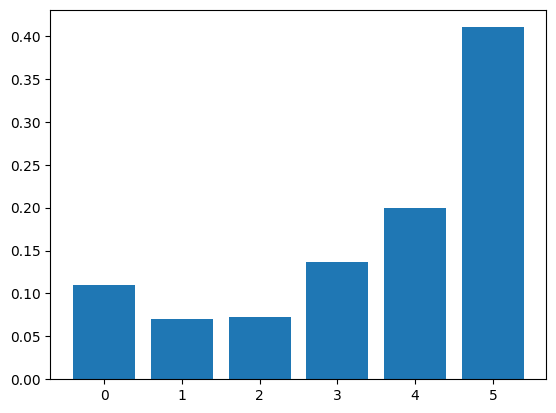

In [146]:
plt.bar(range(len(fi)),fi)

In [147]:
pd.DataFrame(zip(finame,fi),columns=['Feat','FI']).sort_values(by='FI',ascending=False).head(30)

,Feat,FI
0,ratio_pre_avg,0.110125
1,ratio_post_avg,0.069689


In [36]:
hgjkgkkjjkgkj,njmmmb()

NameError: name 'hgjkgkkjjkgkj' is not defined

# ML classical (XGB)

In [48]:
r_train.shape,y_train.shape,r_val.shape,y_val.shape

((811, 60), (811,), (811, 60), (811,))

In [49]:
#convert labels to integers
targets = np.unique(y_train).tolist()
FINAL_MAP_DICT = {targets[i]:i for i in range(len(targets))}

y_train = integer_mapping(y_train, FINAL_MAP_DICT)
y_val = integer_mapping(y_val, FINAL_MAP_DICT)

In [50]:
from xgboost import XGBClassifier
xgbclf = XGBClassifier(n_estimators=100)
xgbclf.fit(r_train[:,feats],y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [51]:
y_true = y_test
y_pred = xgbclf.predict(r_test[:,feats])
y_pred = integer_mapping(y_pred, FINAL_MAP_DICT, inverse=True)

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           A       0.15      0.19      0.17        21
           N       0.98      0.98      0.98      1182
           V       0.00      0.00      0.00         2

    accuracy                           0.97      1205
   macro avg       0.38      0.39      0.38      1205
weighted avg       0.97      0.97      0.97      1205

[[   4   17    0]
 [  22 1160    0]
 [   0    2    0]]


/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [ ]:
jkgkjgkgkgk()

# Binary 

In [ ]:
ds_train = load_data(file_path = '../data/DS1_train.dat')
ds_train = clean_inf_nan(ds_train)
x_train, y_train, r_train = ds_train.values()
y_train = ['Normal' if item=='N' else 'Abnormal' for item in y_train]
#r_train = r_train[:,:] 
r_train.shape 

In [ ]:
%%time
from sklearn import svm
clf = svm.SVC(kernel='rbf',C=0.9)
clf.fit(r_train, y_train)

In [ ]:
#predict
ds_test = load_data(file_path = '../data/DS2.dat')
ds_test = clean_inf_nan(ds_test)
x_test, y_test, r_test = ds_test.values() 
y_test = ['Normal' if item=='N' else 'Abnormal' for item in y_test ]

on_test_set = True

Y_TEST = y_train
X_TEST = r_train
if on_test_set == True:
    Y_TEST = y_test
    X_TEST = r_test

y_pred = clf.predict(X_TEST)
y_pred.shape

In [ ]:
y_pred

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_pred,Y_TEST)

In [ ]:
print(classification_report(y_pred,Y_TEST))